# **Multi-inference implicit chain of reasoning (no teacher) demonstration**

In this notebook I attempt to solve this challenge [here](https://yuntiandeng.com/cv/challenge.png) by referencing the research paper and source code linked below. We are are trying to create a LLM that can solve simultaneous 2 digit by 2 digit multiplication using implicit chain of thought reasoning. **Instead of using a teacher model, I have the emulators use the actual pure CoT implicity to accomplish similar results to the teacher states.**

| ||
|----------|----------|
| Research Credit | [here](https://arxiv.org/pdf/2311.01460.pdf) |
| Code Inspiration Credit | [github](https://github.com/da03/implicit_chain_of_thought/tree/main) |

- We train a thought emulator model to predict pure CoT from input. 
- We have a mind reader emulator that predicts the final output from pure CoT.
- Finally we create the implicit student model, which trains using pre-trained thought and mindreader emulators simultaneously to implicity use pure CoT to predict the output from the input.

In [1]:
import sys
import os

#For safe imports of everything
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)
sys.path.insert(False, parent_directory)

### **Dataset Generation**
Here we generate our test and train data. We generate our training data randomly such that it represents less than **1%** of possible observations. We also generate our tokenized data automatically here as well.

---

The format of training and test datasets follow this format:

```
[input 1a] $ [input 1b]||[CoT 1a] $ [CoT 1b] #### [output 1a] $ [output 1b]
[input 2a] $ [input 2b]||[CoT 2a] $ [CoT 2b] #### [output 2a] $ [output 2b]
[input 3a] $ [input 3b]||[CoT 3a] $ [CoT 3b] #### [output 3a] $ [output 3b]
```

We can also test any particular case using the DatasetHandler so we create a custom prediction dataset as well.

**NOTE** The `DatasetHandler` class has a method `generateDataset`, which may be used to create new randomly generated datasets.

In [2]:
from data.data import DatasetHandler

training_data_size = 777000
test_data_size = 77000

datahandler_train = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'train')
datahandler_test = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'test')

Now we read datasets for each handler. There is also code to generate a new dataset with the same size used in this demo.

In [3]:
datahandler_train.generateDataset(size = training_data_size)

#datahandler_train.readDataset()

Generated raw train dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_train_dataset.txt of size 777000.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_train_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  7 9 * 9 0 $ 0 0 * 6 9 <|endoftext|> 3 7 8 + 0 0 0 0 $ 0 0 0 + 0 0 0 0 <|endoftext|> #### 3 7 8 0 $ 0 0 0 0 <|endoftext|>
No CoT:  7 9 * 9 0 $ 0 0 * 6 9 <|endoftext|> #### 3 7 8 0 $ 0 0 0 0 <|endoftext|>
Only CoT:  7 9 * 9 0 $ 0 0 * 6 9 <|endoftext|> 3 7 8 + 0 0 0 0 $ 0 0 0 + 0 0 0 0 <|endoftext|>
Product input:  7 9 * 9 0 $ 0 0 * 6 9 <|endoftext|> 
Pure CoT input:  7 9 * 9 0 $ 0 0 * 6 9 <|endoftext|> 3 7 8 + 0 0 0 0 $ 0 0 0 + 0 0 0 0 <|endoftext|>
Pure CoT output:  3 7 8 + 0 0 0 0 $ 0 0 0 + 0 0 0 0 <|endoftext|> #### 3 7 8 0 $ 0 0 0 0 <|endoftext|>
---------------------------


In [4]:
datahandler_test.generateDataset(size = test_data_size)

#datahandler_test.readDataset()

Generated raw test dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_test_dataset.txt of size 77000.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_test_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  2 1 * 4 8 $ 5 2 * 1 6 <|endoftext|> 8 4 0 + 0 6 9 0 $ 5 2 0 + 0 0 5 1 <|endoftext|> #### 8 0 0 1 $ 5 2 5 1 <|endoftext|>
No CoT:  2 1 * 4 8 $ 5 2 * 1 6 <|endoftext|> #### 8 0 0 1 $ 5 2 5 1 <|endoftext|>
Only CoT:  2 1 * 4 8 $ 5 2 * 1 6 <|endoftext|> 8 4 0 + 0 6 9 0 $ 5 2 0 + 0 0 5 1 <|endoftext|>
Product input:  2 1 * 4 8 $ 5 2 * 1 6 <|endoftext|> 
Pure CoT input:  2 1 * 4 8 $ 5 2 * 1 6 <|endoftext|> 8 4 0 + 0 6 9 0 $ 5 2 0 + 0 0 5 1 <|endoftext|>
Pure CoT output:  8 4 0 + 0 6 9 0 $ 5 2 0 + 0 0 5 1 <|endoftext|> #### 8 0 0 1 $ 5 2 5 1 <|endoftext|>
---------------------------


Here we allow the creation of a **custom prediction** using input from the jupyter kernel, press enter after each integer. The custom prediction is of the form **a*b** and **c*d**.

In [5]:
#Please provide inputs for the custom test case. Press enter after each integer.
a= int(input("provide int a: "))
b= int(input("provide int b: "))
c= int(input("provide int c: "))
d= int(input("provide int d: "))

print(f"You have provided the input {a}*{b} and {c}*{d} which equals {a*b} and {c*d} respectively.")

custom_prediction = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'custom')
custom_prediction.generateDataset(a=a, b=b, c=c, d=d)

You have provided the input 12*13 and 14*15 which equals 156 and 210 respectively.
Generated raw custom dataset saved at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_custom_dataset.txt of size 1.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot_noteacher\data\raw_custom_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  2 1 * 3 1 $ 4 1 * 5 1 <|endoftext|> 6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 <|endoftext|> #### 6 5 1 0 $ 0 1 2 0 <|endoftext|>
No CoT:  2 1 * 3 1 $ 4 1 * 5 1 <|endoftext|> #### 6 5 1 0 $ 0 1 2 0 <|endoftext|>
Only CoT:  2 1 * 3 1 $ 4 1 * 5 1 <|endoftext|> 6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 <|endoftext|>
Product input:  2 1 * 3 1 $ 4 1 * 5 1 <|endoftext|> 
Pure CoT input:  2 1 * 3 1 $ 4 1 * 5 1 <|endoftext|> 6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 <|endoftext|>
Pure CoT output:  6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 <|endoftext|>

### **Model Training**
Here we begin training our individual models. First we import everything we need.

---


In [6]:
from source.thought_emulator import ThoughtEmulator
from source.configurations import ThoughtEmulatorConfig

from source.mindreading_emulator import MindReadingEmulator
from source.configurations import MindReadingEmulatorConfig

from source.implicit_student import ImplicitStudent

Now we initialize the configurations and models.

In [7]:
t_emulator_config = ThoughtEmulatorConfig()
t_emulator_model = ThoughtEmulator(t_emulator_config)

mr_emulator_config = MindReadingEmulatorConfig()
mr_emulator_model = MindReadingEmulator(mr_emulator_config)

implicit_model = ImplicitStudent(mr_emulator_config, mindread = mr_emulator_model, thought = t_emulator_model)

##### **Thought Emulator Model**
This model takes the input and predicts the pure CoT.

  0%|          | 1/24282 [00:03<24:59:54,  3.71s/it]

Step: 0. Loss: 4.415676. Training Accuracy: 0.152961


 10%|█         | 2430/24282 [09:40<1:25:26,  4.26it/s]

Step: 2429. Loss: 0.001285. Training Accuracy: 1.000000


 20%|██        | 4859/24282 [19:12<1:16:33,  4.23it/s]

Step: 4858. Loss: 0.000933. Training Accuracy: 1.000000


 30%|███       | 7288/24282 [29:17<1:06:50,  4.24it/s]

Step: 7287. Loss: 0.000181. Training Accuracy: 1.000000


 40%|████      | 9717/24282 [39:08<1:03:18,  3.83it/s]

Step: 9716. Loss: 0.000201. Training Accuracy: 1.000000


 50%|█████     | 12146/24282 [49:15<55:31,  3.64it/s]  

Step: 12145. Loss: 0.000012. Training Accuracy: 1.000000


 60%|██████    | 14575/24282 [59:42<38:48,  4.17it/s]

Step: 14574. Loss: 0.000421. Training Accuracy: 1.000000


 70%|███████   | 17004/24282 [1:09:17<28:36,  4.24it/s]  

Step: 17003. Loss: 0.000865. Training Accuracy: 1.000000


 80%|████████  | 19433/24282 [1:18:48<19:01,  4.25it/s]

Step: 19432. Loss: 0.000069. Training Accuracy: 1.000000


 90%|█████████ | 21862/24282 [1:28:35<09:30,  4.25it/s]

Step: 21861. Loss: 0.000039. Training Accuracy: 1.000000


100%|██████████| 24282/24282 [1:38:18<00:00,  4.12it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [11:20<00:00,  3.54it/s]

Input:  6 9 * 0 1 $ 6 7 * 1 4 
Target:  0 0 0 + 0 6 9 0 $ 6 7 0 + 0 4 0 3 
Predicted:  0 0 0 + 0 6 9 0 $ 6 7 0 + 0 4 0 3

Input:  0 2 * 9 9 $ 7 9 * 6 6 
Target:  0 8 1 + 0 0 8 1 $ 2 8 5 + 0 2 8 5 
Predicted:  0 8 1 + 0 0 8 1 $ 2 8 5 + 0 2 8 5

Input:  7 0 * 2 6 $ 7 8 * 7 1 
Target:  4 1 0 + 0 2 4 0 $ 9 0 6 + 0 7 8 0 
Predicted:  4 1 0 + 0 2 4 0 $ 9 0 6 + 0 7 8 0

→ PPL: 1.000000; Test Accuracy: 1.000000; Training Accuracy: 1.000000.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\thought_emulator


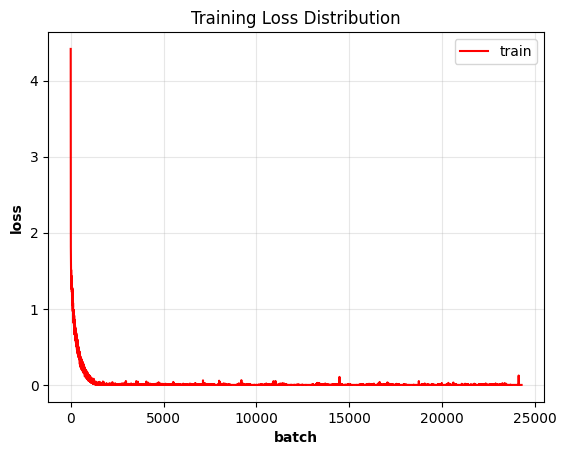

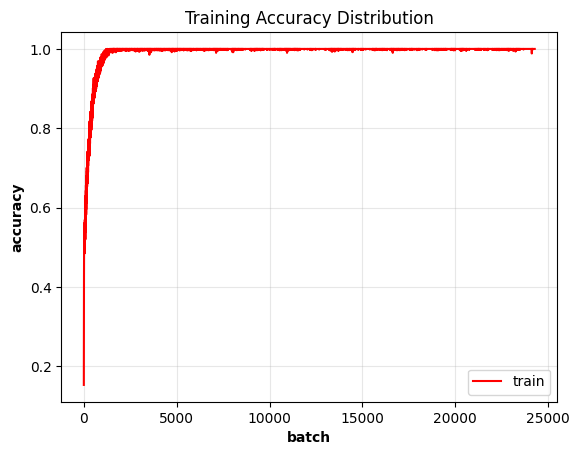

In [8]:
t_emulator_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

##### **Mind Reading Emulator Model**
This model takes in the pure CoT as input and predicts the output.

  0%|          | 1/24282 [00:00<1:40:54,  4.01it/s]

Step: 0. PPL: 198.681076. Training Accuracy: 0.146382


 10%|█         | 2430/24282 [09:33<1:25:44,  4.25it/s]

Step: 2429. PPL: 1.323099. Training Accuracy: 0.896382


 20%|██        | 4859/24282 [19:14<1:16:11,  4.25it/s]

Step: 4858. PPL: 1.314429. Training Accuracy: 0.891447


 30%|███       | 7288/24282 [28:49<1:08:10,  4.15it/s]

Step: 7287. PPL: 1.289896. Training Accuracy: 0.907895


 40%|████      | 9717/24282 [38:25<57:31,  4.22it/s]  

Step: 9716. PPL: 1.254933. Training Accuracy: 0.911184


 50%|█████     | 12146/24282 [48:00<47:49,  4.23it/s]

Step: 12145. PPL: 1.237098. Training Accuracy: 0.921053


 60%|██████    | 14575/24282 [57:35<38:13,  4.23it/s]

Step: 14574. PPL: 1.229071. Training Accuracy: 0.925987


 70%|███████   | 17004/24282 [1:07:22<28:40,  4.23it/s]

Step: 17003. PPL: 1.188036. Training Accuracy: 0.934211


 80%|████████  | 19433/24282 [1:17:16<19:07,  4.23it/s]

Step: 19432. PPL: 1.212677. Training Accuracy: 0.919408


 90%|█████████ | 21862/24282 [1:27:19<09:32,  4.23it/s]

Step: 21861. PPL: 1.170219. Training Accuracy: 0.940789


100%|██████████| 24282/24282 [1:36:53<00:00,  4.18it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [09:53<00:00,  4.05it/s]


Input:  0 0 0 + 0 6 9 0 $ 6 7 0 + 0 4 0 3 
Target:  #### 0 6 9 0 $ 6 1 1 3 
Predicted:  #### 0 6 9 0 $ 6 1 1 3 

Input:  0 8 1 + 0 0 8 1 $ 2 8 5 + 0 2 8 5 
Target:  #### 0 8 9 1 $ 2 0 4 6 
Predicted:  #### 0 8 9 1 $ 2 0 4 6 

Input:  4 1 0 + 0 2 4 0 $ 9 0 6 + 0 7 8 0 
Target:  #### 4 3 4 0 $ 9 7 4 1 
Predicted:  #### 4 3 4 0 $ 9 7 4 1 

→ PPL: 1.187874; Test Accuracy: 1.000000. Training Accuracy: 0.930459.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\thought_emulator


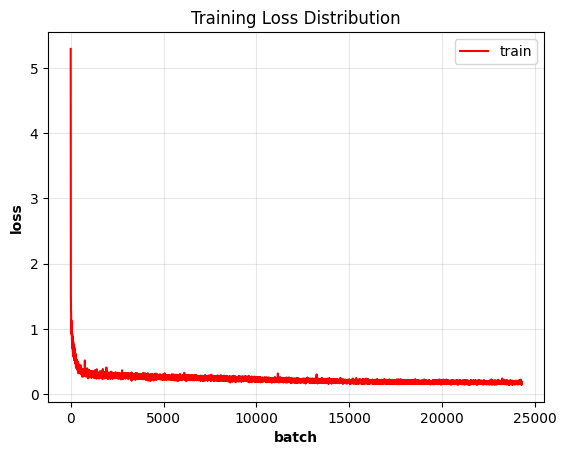

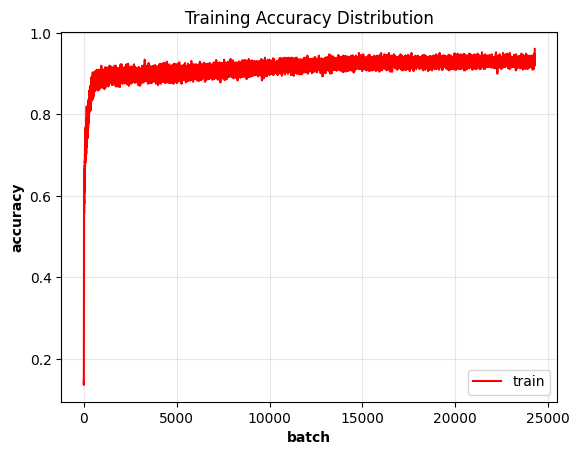

In [9]:
mr_emulator_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

##### **Implicit Model**
This model takes the input and predicts the pure CoT, and uses the pure CoT to predict the output. The pure CoT is used implicitly to mimic CoT reasoning internally. 

**NOTE** It trains using both a pretrained thought emulator and the mind emulator model, so make sure to train them in order.

  0%|          | 1/24282 [00:00<2:47:18,  2.42it/s]

Step: 0. CrossEntropyLoss: 10.375539. Training Accuracy: 0.326923.


 10%|█         | 2430/24282 [15:23<2:17:24,  2.65it/s]

Step: 2429. CrossEntropyLoss: 0.309508. Training Accuracy: 0.882212.


 20%|██        | 4859/24282 [31:36<2:03:03,  2.63it/s]

Step: 4858. CrossEntropyLoss: 0.025518. Training Accuracy: 0.992788.


 30%|███       | 7288/24282 [47:10<1:48:25,  2.61it/s]

Step: 7287. CrossEntropyLoss: 0.020709. Training Accuracy: 0.990385.


 40%|████      | 9717/24282 [1:02:39<1:37:29,  2.49it/s]

Step: 9716. CrossEntropyLoss: 0.005306. Training Accuracy: 0.997596.


 50%|█████     | 12146/24282 [1:18:13<1:17:19,  2.62it/s]

Step: 12145. CrossEntropyLoss: 0.000315. Training Accuracy: 1.000000.


 60%|██████    | 14575/24282 [1:34:00<1:10:12,  2.30it/s]

Step: 14574. CrossEntropyLoss: 0.002238. Training Accuracy: 1.000000.


 70%|███████   | 17004/24282 [1:49:37<46:19,  2.62it/s]  

Step: 17003. CrossEntropyLoss: 0.003549. Training Accuracy: 0.997596.


 80%|████████  | 19433/24282 [2:05:38<33:56,  2.38it/s]

Step: 19432. CrossEntropyLoss: 0.003731. Training Accuracy: 1.000000.


 90%|█████████ | 21862/24282 [2:21:45<15:44,  2.56it/s]

Step: 21861. CrossEntropyLoss: 0.003671. Training Accuracy: 1.000000.


100%|██████████| 24282/24282 [2:37:13<00:00,  2.57it/s]


✔ Evaluating test dataset now...


100%|██████████| 2407/2407 [15:57<00:00,  2.51it/s]

Input:  6 9 * 0 1 $ 6 7 * 1 4 
Target:  #### 0 6 9 0 $ 6 1 1 3 
Predicted:  #### 0 6 9 0 $ 6 1 1 3 

Input:  0 2 * 9 9 $ 7 9 * 6 6 
Target:  #### 0 8 9 1 $ 2 0 4 6 
Predicted:  #### 0 8 9 1 $ 2 0 4 6 

Input:  7 0 * 2 6 $ 7 8 * 7 1 
Target:  #### 4 3 4 0 $ 9 7 4 1 
Predicted:  #### 4 3 4 0 $ 9 7 4 1 

→ Perplexitity: 1.000026; Test Accuracy: 1.000000; Training Accuracy: 1.000000.
Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\implict_thought_emulator


Saving to c:\Users\Luke\multi_implicit_cot_noteacher\models\implict_mindreading_emulator


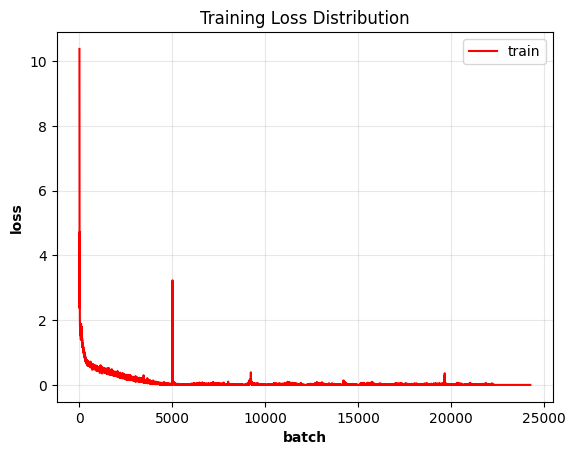

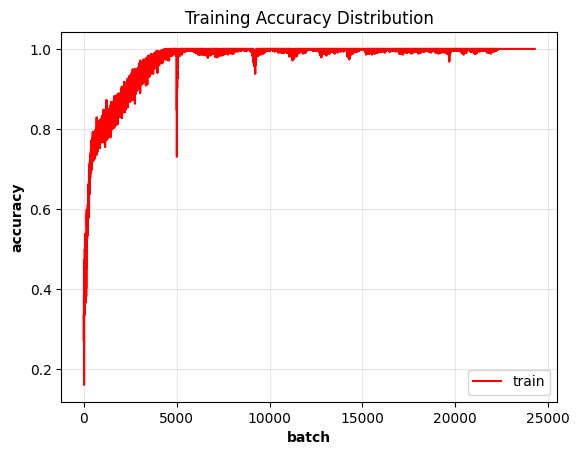

In [10]:
implicit_model.trainModel(train_handler = datahandler_train, test_handler = datahandler_test, limit = 1)

### **Prediction Demo**
Here we generate our custom test case to see results for each model. We include both the **thought emulator** and **mind reading emulator** to see how well it maps to and from teacher states.

---

In [11]:
t_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Input:  2 1 * 3 1 $ 4 1 * 5 1 
Target:  6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 
Predicted:  6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0



In [12]:
mr_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

Input:  6 3 0 + 0 2 1 0 $ 0 7 0 + 0 4 1 0 
Target:  #### 6 5 1 0 $ 0 1 2 0 
Predicted:  #### 0 0 0 0 0 2 0 



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


In [13]:
implicit_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

Input:  2 1 * 3 1 $ 4 1 * 5 1 
Target:  #### 6 5 1 0 $ 0 1 2 0 
Predicted:  #### 6 5 1 0 $ 0 1 2 0 

